Task1_0726. 신용카드 사기 검출 모델을 아래와 같이 생성하고 평가하세요.

- 데이터 일차 가공 및 모델 학습/예측/평가
  - Time 컬럼 삭제, 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가

- Amount 컬럼 데이터 분포도 변환 후 모델 학습/예측/평가
  - 표준화한 후 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가

- 이상치 데이터 제거 후 모델 학습/예측/평가
  - 데이터의 상관관계를 시각화 V14와 클래스의 상관관계 높음을 확인 후 V14 컬럼의 이상치 제거한 후 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가

- SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
  - 불균형한 데이터셋 처리를 위한 imbalanced-learn 라이브러리를 설치
  - %pip install imbalanced-learn
  - SMOTE(Synthetic Minority Over-sampling Technique)를 사용하여 불균형한 데이터셋을 처리
  - from imblearn.over_sampling import SMOTE
  - smote = SMOTE(random_state=0)
  - X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
  - SMOTE를 적용한 학습 데이터셋을 사용하여 로지스틱 회귀 모델을 학습하고 예측 성능을 평가
  - Precision-Recall 커브를 시각화하는 함수
  - LightGBM을 이용하여 모델링 및 평가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
file_path='/content/drive/MyDrive/KDT_240424/m5_ML/dataset/creditcard.csv'
data=pd.read_csv(file_path)
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### Step 1. 데이터 1차 가공 및 모델 학습/예측/평가
- 결측치 확인 및 있을 경우 삭제하여 진행

###### 1-1. 데이터 작업

In [ ]:
# 데이터 카피
data1=data.copy()

In [ ]:
# 1. 데이터 확인
data1.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
# 1. 데이터 확인
data1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


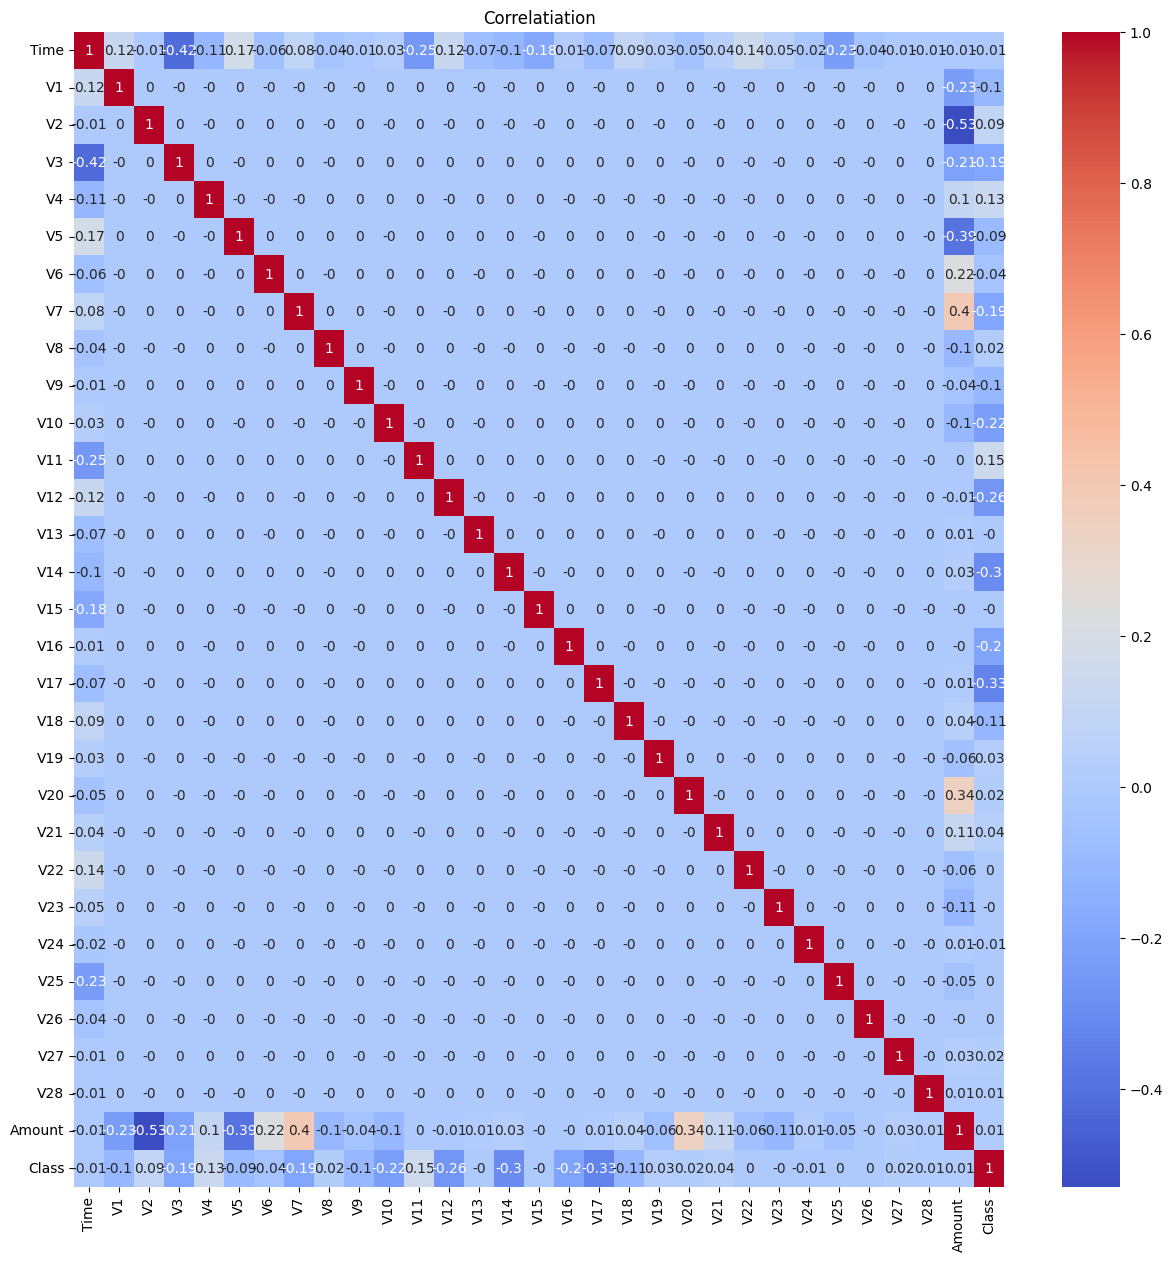

In [ ]:
correlation_matrix=data1.corr()

# 2. 상관관계 히트맵으로 시각화
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='coolwarm')
plt.title('Correlatiation')
plt.show()

###### 1-2. 모델 훈련 및 평가

In [ ]:
# 모델 훈련 및 평가 함수

def train_and_evaluate(model,x_train, x_test, y_train, y_test):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    y_proba=model.predict_proba(x_test)[:, 1]

    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_proba)
    confusion=confusion_matrix(y_test, y_pred)
    classification_rep=classification_report(y_test, y_pred)

    print(f"오차 행렬: \n{confusion}")
    print(f"정확도: {accuracy: .4f}")
    print(f"정밀도: {precision: .4f}")
    print(f"재현율: {recall: .4f}")
    print(f"f1 스코어: {f1: .4f}")
    print(f"ROC AUC: {roc_auc: .4f}")
    print(f'Classification Report: {classification_rep}')

# 여러 모델 훈련 및 평가
models={
    'Logistic Regression': LogisticRegression(max_iter=500, solver='lbfgs', random_state=59),
    'Random Forest': RandomForestClassifier(random_state=59),
    # 'Deceision Tree': DecisionTreeClassifier(random_state=59),
    # 'SVM_linear': SVC(kernel='linear', probability=True, C=1.0, random_state=59),
    # 'SVM_poly': SVC(kernel='poly', probability=True, C=1.0, random_state=59),
    # 'SVM_rbf': SVC(kernel='rbf', probability=True, C=1.0, random_state=59),
    # 'GBM': GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=59),
    # 'XGB': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    # 'LGBM': LGBMClassifier(n_estimators=100, learning_rate=0.05, verbose=-1),
    # 'GNB': GaussianNB()
}


In [ ]:
# 데이터 나누기
x=data1.drop('Class', axis=1)
y=data1['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=59)

# 각 모델별 함수 실행
for model_name, model in models.items():
    print(f'[{model_name}]')
    train_and_evaluate(model, x_train, x_test, y_train, y_test)

[Logistic Regression]
오차 행렬: 
[[56838    15]
 [   47    62]]
정확도:  0.9989
정밀도:  0.8052
재현율:  0.5688
f1 스코어:  0.6667
ROC AUC:  0.9561
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56853
           1       0.81      0.57      0.67       109

    accuracy                           1.00     56962
   macro avg       0.90      0.78      0.83     56962
weighted avg       1.00      1.00      1.00     56962

[Random Forest]


KeyboardInterrupt: 

In [ ]:
# 실행한 모델 중 가장 정확도 > 재현율 > 정밀도 높은 모델은:
# 너무 오래걸려서 중단함 (SVM 진행중일때 30분 초과함)

### 2. 탐색적 분석을 통한 결측치 처리 및 모델 학습/예측/평가
- Amount 컬럼 데이터 분포도 변환 후 모델 학습/예측/평가

- 표준화한 후 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가

##### 2-1. 데이터 작업

In [ ]:
# 새 작업을 위한 데이터 카피
data2=data.copy()

In [ ]:
# Amount 컬럼 데이터 분포도 변환 후 모델 학습/예측/평가
# 'Amount' 열 확인
data2['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

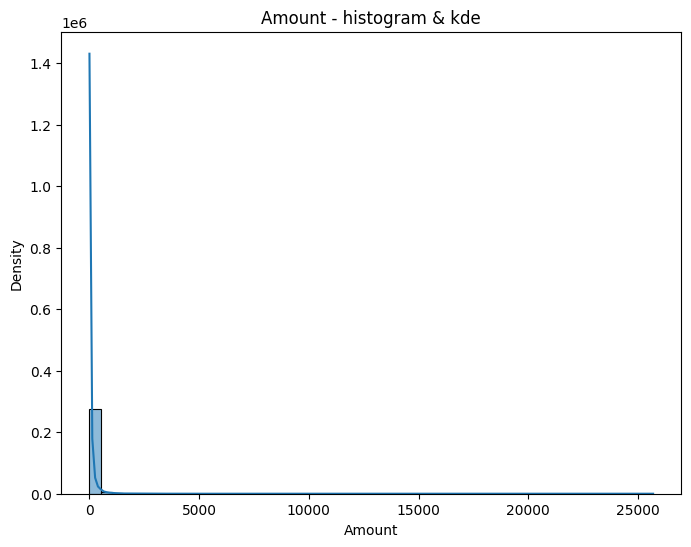

In [ ]:
# 'Amount' 열 분포도 확인
# 히스토 그램 + KDE
plt.figure(figsize=(8,6))
sns.histplot(data2['Amount'], bins=50, kde=True)
plt.title('Amount - histogram & kde')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

In [ ]:
# 'Amount' 이상치 제거
# 1. percentile로 나눠 보기 :
amount_percentiles=np.percentile(data2['Amount'], np.arange(0,110,10))
print('Percentiles(0% to 100%):', amount_percentiles)


Percentiles(0% to 100%): [0.000000e+00 1.000000e+00 3.570000e+00 8.910000e+00 1.300000e+01
 2.200000e+01 3.700000e+01 5.980000e+01 1.000000e+02 2.030000e+02
 2.569116e+04]


In [ ]:
# 2. 1000 이상 몇개인지 확인 :
data.loc[(data2['Amount']>2500)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
164,103.0,-6.093248,-12.114213,-5.694973,3.294389,-1.413792,4.776000,4.808426,-0.228197,-0.525896,...,2.228823,-2.264037,-3.553381,1.215279,-0.406073,-0.653384,-0.711222,0.672900,3828.04,0
1632,1264.0,-11.140706,-9.612726,-12.389545,6.013346,-32.092129,21.393069,34.303177,-7.520784,-1.925732,...,-4.709977,1.366110,-2.925888,0.843551,0.746267,0.801387,3.852046,4.157934,7712.43,0
2178,1698.0,-5.849226,-11.754975,-3.333303,3.673246,-4.459583,0.659098,4.527224,-0.985512,0.237794,...,2.160870,-1.992179,-3.240351,0.609619,-0.985548,0.089693,-0.713355,0.653060,3669.00,0
2453,2019.0,-3.687481,-8.746635,-2.057885,1.858936,-3.353004,1.580542,2.399114,-0.318630,-1.045750,...,1.230193,-1.573274,-2.122351,-0.141325,-0.838373,0.251148,-0.440547,0.445717,2540.42,0
2622,2151.0,-2.574940,-2.669331,-3.080133,2.043551,-11.416881,7.885721,12.219249,-1.828209,-1.475925,...,-0.115580,0.264090,2.219739,-0.771131,0.145438,-0.240517,1.180441,-0.623651,2909.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281375,170137.0,-1.965632,1.301630,-4.354657,2.757797,-13.289029,10.085792,15.364280,-4.554727,-2.568326,...,0.131940,-0.407096,-0.525327,1.004851,-0.226852,-0.179945,2.326879,-1.326722,3100.00,0
281611,170302.0,-5.034683,-12.155822,-4.527769,2.219104,-4.375383,0.380424,4.385223,-1.140605,0.892836,...,2.058558,-2.221445,-2.833333,0.145944,-1.957437,-0.052993,-0.720871,0.593201,3670.00,0
283315,171514.0,-2.740984,-2.586374,-5.803083,-0.812563,-10.954787,6.380773,13.992227,-2.435900,-2.882009,...,-0.236493,0.416872,1.669461,-0.860928,1.011840,1.058176,0.774090,-0.898281,2992.05,0
283395,171560.0,-6.519366,-10.723215,-4.631726,0.074792,-9.973646,7.975968,12.793781,-0.541910,-2.328088,...,2.215869,-0.362451,9.113598,-1.460900,0.602284,-0.693933,-1.111301,0.444162,3820.86,0


In [ ]:
# 3. 일단 2500 이상은 제거하고, Q1, Q3 확인하기
con1=(data2['Amount']>2500)
data2.drop(data2[con1].index, inplace=True)

In [ ]:
data2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,...,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000,284367.000000
mean,94818.304884,0.010963,0.017529,0.007938,-0.004174,0.011575,-0.006407,-0.012854,0.003049,0.000864,...,-0.001936,0.001909,0.002153,-0.000209,0.000946,0.000268,-0.000503,0.000006,82.494572,0.001730
std,47490.725274,1.926416,1.559245,1.496554,1.409221,1.304761,1.301923,1.140635,1.186784,1.097736,...,0.725235,0.721833,0.558487,0.605182,0.517120,0.481855,0.391179,0.322433,184.033509,0.041559
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-23.669726,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-8.887017,-36.666000,-2.836627,-7.495741,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,54214.500000,-0.916275,-0.594653,-0.884051,-0.849731,-0.688004,-0.768977,-0.554815,-0.207371,-0.642042,...,-0.228455,-0.540987,-0.161324,-0.354596,-0.316367,-0.326741,-0.070636,-0.052949,5.530000,0.000000
50%,84697.000000,0.021124,0.067328,0.182170,-0.021840,-0.052817,-0.275659,0.038866,0.022955,-0.050706,...,-0.029798,0.007665,-0.011003,0.040849,0.017093,-0.051773,0.001442,0.011193,21.990000,0.000000
75%,139329.000000,1.316271,0.804744,1.028372,0.739389,0.612851,0.394795,0.567747,0.328051,0.597557,...,0.185602,0.529161,0.147607,0.439236,0.350787,0.240929,0.091017,0.077892,76.655000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.491217,34.801666,16.614054,21.014587,20.007208,15.594995,...,27.202839,10.503090,22.083545,4.022866,7.519589,3.517346,10.507884,33.847808,2500.000000,1.000000


In [ ]:
# 4. amount>2500 삭제 완료. Q1, Q3 확인하기
Q1=data2['Amount'].quantile(0.25)
Q3=data2['Amount'].quantile(0.75)
IQR=Q3-Q1
upper_bound=Q3+1.5*IQR
median = data2['Amount'].median()

print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')
print(f'upper_bound : {upper_bound}')
print(f'median: {median}')

Q1: 5.53
Q3: 76.655
IQR: 71.125
upper_bound : 183.3425
median: 21.99


In [ ]:
# 이상치 삭제
con2=(data2['Amount']>185)
data2.drop(data2[con2].index, inplace=True)

In [ ]:
data2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,...,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000,253014.000000
mean,94991.637463,0.094539,0.230062,0.060566,-0.018911,0.116456,-0.059141,-0.083715,0.024814,0.008664,...,-0.018524,0.002761,0.006623,0.001941,0.002274,-0.001890,0.002236,-0.001575,35.040669,0.001585
std,47592.912774,1.820169,1.293528,1.470994,1.393852,1.214632,1.264534,1.038824,1.156960,1.081364,...,0.705098,0.714164,0.433910,0.602692,0.505767,0.469115,0.371106,0.266217,42.279754,0.039779
min,0.000000,-40.470142,-47.429676,-33.680984,-5.683171,-23.669726,-23.496714,-43.557242,-41.484823,-13.434066,...,-22.797604,-8.887017,-36.666000,-2.836627,-7.495741,-1.732008,-9.895244,-8.478686,0.000000,0.000000
25%,54540.000000,-0.859667,-0.398284,-0.816744,-0.850166,-0.567579,-0.793009,-0.576971,-0.196258,-0.615939,...,-0.237498,-0.544678,-0.141849,-0.355212,-0.314591,-0.322209,-0.063974,-0.054099,4.490000,0.000000
50%,85051.500000,0.035490,0.165509,0.225460,-0.024458,0.021003,-0.318695,0.015999,0.029398,-0.045366,...,-0.047264,0.006129,-0.005044,0.040305,0.012914,-0.041108,0.006937,0.008814,16.000000,0.000000
75%,139584.500000,1.356819,0.878169,1.067541,0.717159,0.666392,0.311531,0.515722,0.335353,0.583820,...,0.158613,0.529006,0.141509,0.439070,0.349265,0.229645,0.096216,0.072325,50.000000,0.000000
max,172788.000000,2.454930,22.057729,4.226108,12.114672,34.099309,8.933762,6.491054,20.007208,10.392889,...,27.202839,8.361985,22.083545,4.022866,7.519589,3.463246,8.254376,22.620072,185.000000,1.000000


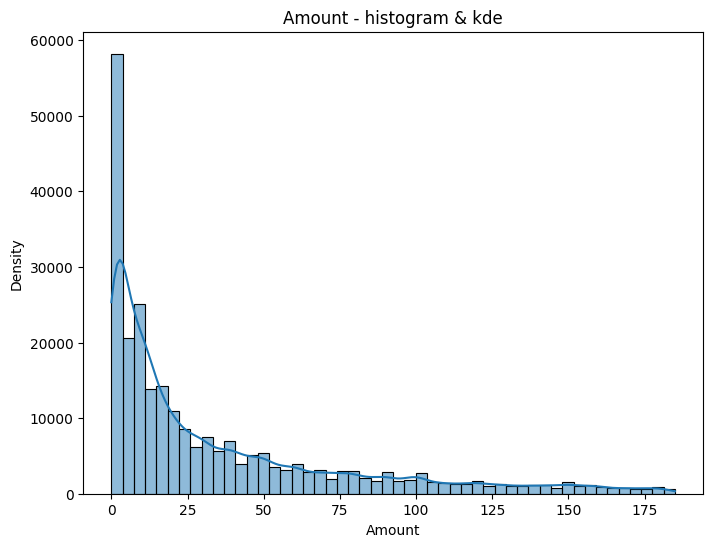

In [ ]:
# 이상치 제거한 'Amount' 열 분포도 확인
# 히스토 그램 + KDE
plt.figure(figsize=(8,6))
sns.histplot(data2['Amount'], bins=50, kde=True)
plt.title('Amount - histogram & kde')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

##### 2-2. 모델 훈련 및 평가

In [ ]:
# 데이터 나누기
x=data2.drop('Class', axis=1)
y=data2['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=59)

In [ ]:
# 데이터 표준화
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
# 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가
models2={
    'Logistic Regression':LogisticRegression(max_iter=500, solver='lbfgs', random_state=59),
    'LGBM': LGBMClassifier(n_estimators=100, learning_rate=0.05, verbose=-1)
}

# 각 모델별 함수 실행
for model_name, model in models2.items():
    print(f'[{model_name}]')
    train_and_evaluate(model, x_train, x_test, y_train, y_test)

[Logistic Regression]
오차 행렬: 
[[50513     9]
 [   33    48]]
정확도:  0.9992
정밀도:  0.8421
재현율:  0.5926
f1 스코어:  0.6957
ROC AUC:  0.9788
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50522
           1       0.84      0.59      0.70        81

    accuracy                           1.00     50603
   macro avg       0.92      0.80      0.85     50603
weighted avg       1.00      1.00      1.00     50603

[LGBM]
오차 행렬: 
[[50505    17]
 [   23    58]]
정확도:  0.9992
정밀도:  0.7733
재현율:  0.7160
f1 스코어:  0.7436
ROC AUC:  0.8981
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50522
           1       0.77      0.72      0.74        81

    accuracy                           1.00     50603
   macro avg       0.89      0.86      0.87     50603
weighted avg       1.00      1.00      1.00     50603



### 3. 이상치 데이터 제거 후 모델 학습/예측/평가

- 데이터의 상관관계를 시각화 V14와 클래스의 상관관계 높음을 확인 후 V14 컬럼의 이상치 제거한 후 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가

##### 3-1. 데이터 작업

In [ ]:
# 데이터 카피
data3=data2.copy()

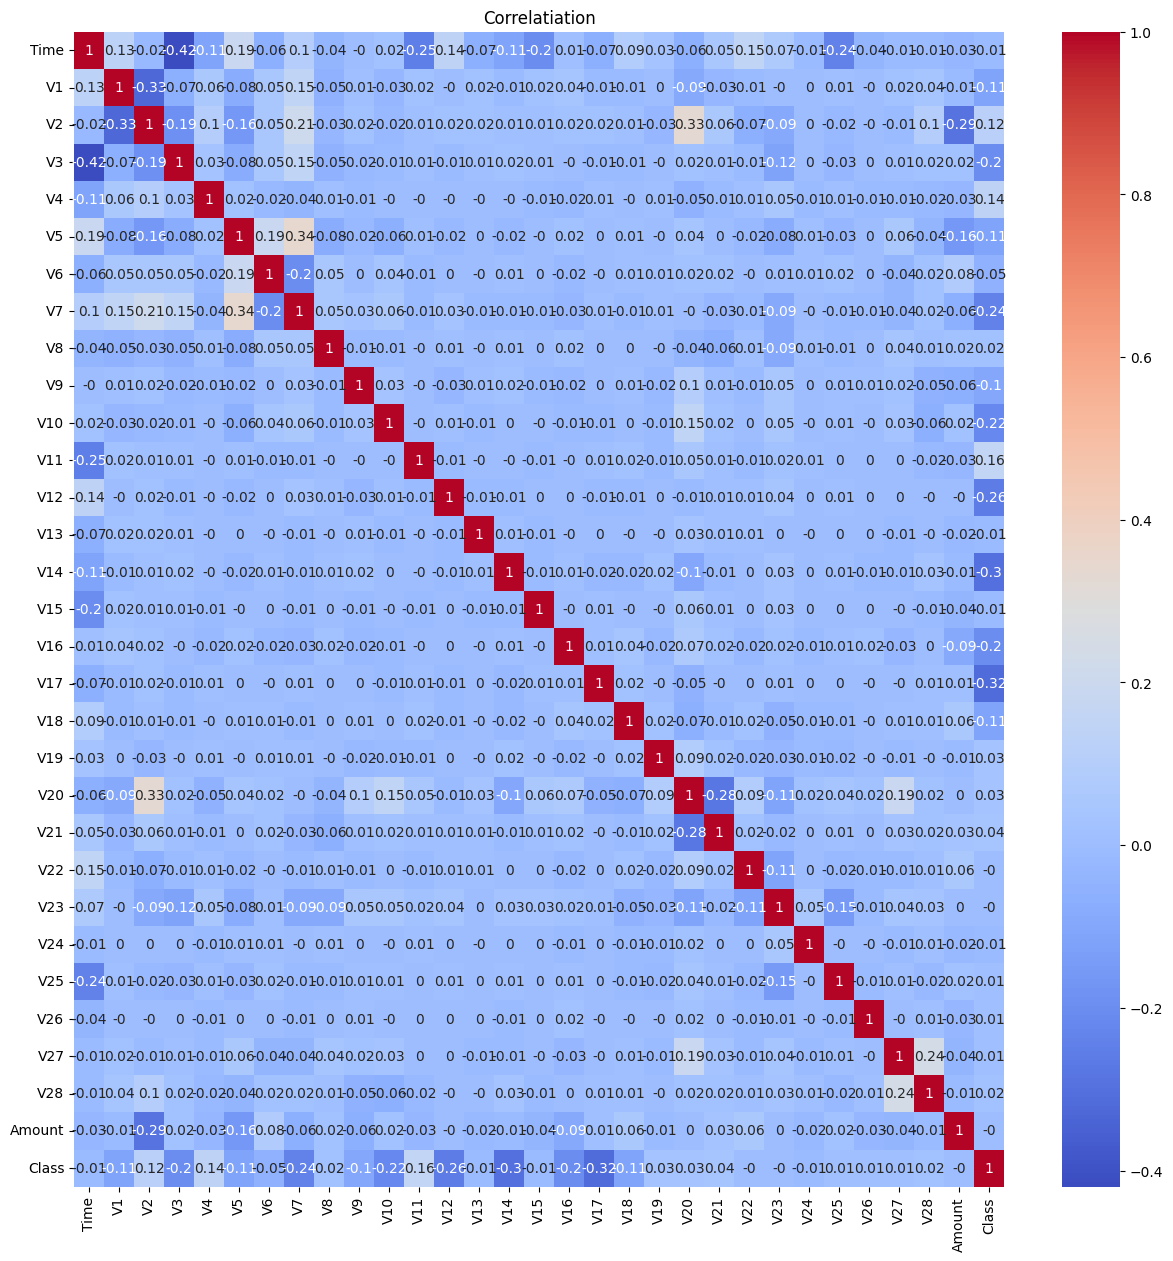

In [ ]:
# 데이터의 상관관계를 시각화 V14와 클래스의 상관관계 높음을 확인 후 V14 컬럼의 이상치 제거
# 1. 각 열의 상관관계
correlation_matrix=data3.corr()

# 2. 상관관계 히트맵으로 시각화
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='coolwarm')
plt.title('Correlatiation')
plt.show()

In [ ]:
# 각 열의 이상치 확인 :
columns=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']

def outlier_detect(data3):
    for column in columns:
        Q1=data3[column].quantile(0.25).round(3)
        Q3=data3[column].quantile(0.75).round(3)
        IQR=(Q3-Q1).round(3)
        min=data3[column].min().round(3)
        lower_bound=(Q3-1.5*IQR).round(3)
        max=data3[column].max().round(3)
        upper_bound=(Q3+1.5*IQR).round(3)
        median = data3[column].median().round(3)

        print(f"변수명: {column}")

        print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, min: {min}, lower_bound: {lower_bound},  max: {max},upper_bound : {upper_bound}, median: {median}')

outlier_detect(data3)

변수명: V1
Q1: -0.86, Q3: 1.357, IQR: 2.217, min: -40.47, lower_bound: -1.968,  max: 2.455,upper_bound : 4.682, median: 0.035
변수명: V2
Q1: -0.398, Q3: 0.878, IQR: 1.276, min: -47.43, lower_bound: -1.036,  max: 22.058,upper_bound : 2.792, median: 0.166
변수명: V3
Q1: -0.817, Q3: 1.068, IQR: 1.885, min: -33.681, lower_bound: -1.76,  max: 4.226,upper_bound : 3.896, median: 0.225
변수명: V4
Q1: -0.85, Q3: 0.717, IQR: 1.567, min: -5.683, lower_bound: -1.633,  max: 12.115,upper_bound : 3.068, median: -0.024
변수명: V5
Q1: -0.568, Q3: 0.666, IQR: 1.234, min: -23.67, lower_bound: -1.185,  max: 34.099,upper_bound : 2.517, median: 0.021
변수명: V6
Q1: -0.793, Q3: 0.312, IQR: 1.105, min: -23.497, lower_bound: -1.346,  max: 8.934,upper_bound : 1.97, median: -0.319
변수명: V7
Q1: -0.577, Q3: 0.516, IQR: 1.093, min: -43.557, lower_bound: -1.124,  max: 6.491,upper_bound : 2.156, median: 0.016
변수명: V8
Q1: -0.196, Q3: 0.335, IQR: 0.531, min: -41.485, lower_bound: -0.461,  max: 20.007,upper_bound : 1.132, median: 0.029
변수

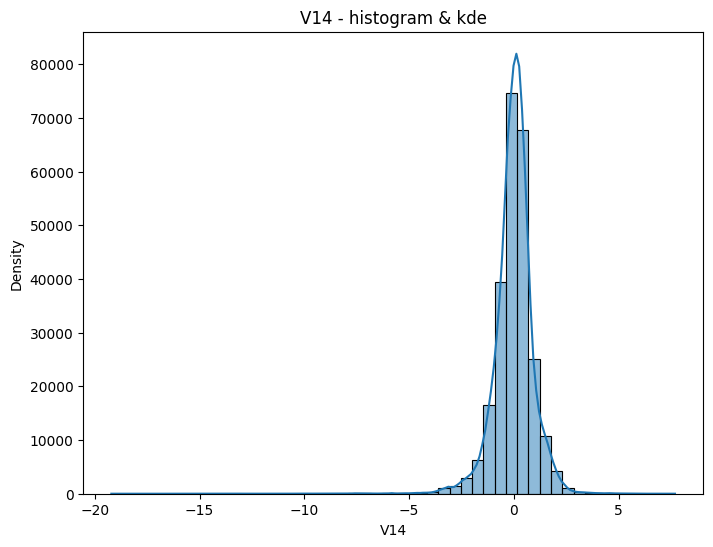

In [ ]:
# V14의 분포도만 따로 확인
# 히스토 그램 + KDE
plt.figure(figsize=(8,6))
sns.histplot(data3['V14'], bins=50, kde=True)
plt.title('V14 - histogram & kde')
plt.xlabel('V14')
plt.ylabel('Density')
plt.show()

# 변수명: V14
# Q1: -0.43, Q3: 0.487, IQR: 0.917, min: -19.214, lower_bound: -0.889,  max: 7.692,upper_bound : 1.863, median: 0.048

In [ ]:
# 지시에 맞춰 하려면 V14의 lowerbound 이상 넘어간거 삭제해봐야할듯...???


##### 3-2. 모델 훈련 및 평가


In [ ]:
# 데이터 나누기
x=data3.drop('Class', axis=1)
y=data3['Class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=59)

In [ ]:
# 데이터 표준화
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
# 로지스틱 회귀, LightGBM을 이용하여 모델링 및 평가
models3={
    'Logistic Regression':LogisticRegression(max_iter=500, solver='lbfgs', random_state=59),
    'LGBM': LGBMClassifier(n_estimators=100, learning_rate=0.05, verbose=-1)
}

# 각 모델별 함수 실행
for model_name, model in models3.items():
    print(f'[{model_name}]')
    train_and_evaluate(model, x_train, x_test, y_train, y_test)

[Logistic Regression]
오차 행렬: 
[[50513     9]
 [   33    48]]
정확도:  0.9992
정밀도:  0.8421
재현율:  0.5926
f1 스코어:  0.6957
ROC AUC:  0.9788
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50522
           1       0.84      0.59      0.70        81

    accuracy                           1.00     50603
   macro avg       0.92      0.80      0.85     50603
weighted avg       1.00      1.00      1.00     50603

[LGBM]
오차 행렬: 
[[50505    17]
 [   23    58]]
정확도:  0.9992
정밀도:  0.7733
재현율:  0.7160
f1 스코어:  0.7436
ROC AUC:  0.8981
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50522
           1       0.77      0.72      0.74        81

    accuracy                           1.00     50603
   macro avg       0.89      0.86      0.87     50603
weighted avg       1.00      1.00      1.00     50603



### 4. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
# 불균형한 데이터셋 처리를 위한 imbalanced-learn 라이브러리를 설치
# %pip install imbalanced-learn
# SMOTE(Synthetic Minority Over-sampling Technique)를 사용하여 불균형한 데이터셋을 처리
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=0)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
# SMOTE를 적용한 학습 데이터셋을 사용하여 로지스틱 회귀 모델을 학습하고 예측 성능을 평가
# Precision-Recall 커브를 시각화하는 함수
# LightGBM을 이용하여 모델링 및 평가

In [ ]:
%pip install imbalanced-learn

### 강사님 풀이

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')


card_df = pd.read_csv('/content/drive/MyDrive/KDT_240424/m5_ML/dataset/creditcard.csv')
card_df.head(3)

In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
# 데이터를 전처리하는 get_preprocessed_df 함수
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
y_train.value_counts()

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_clf = LogisticRegression(max_iter=100, solver='lbfgs', random_state=42)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
# 신용카드 거래 금액('Amount')의 히스토그램을 생성
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
# np.log1p 함수를 사용하여 'Amount' 피처를 로그 변환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
# 이 셀에서는 로그 변환된 'Amount' 피처를 사용하여 로지스틱 회귀와 LightGBM 모델을 다시 학습하고 예측 성능을 평가
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
# 데이터의 상관 관계를 시각화 : v14, v17이 class와 상관관계가 높음
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
# 데이터에서 이상치를 찾는 get_outlier 함수를 정의
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
# get_outlier 함수를 호출하여 'V14' 피처의 이상치 인덱스를 찾고, 이를 출력
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

##### SMOTE

In [ ]:
# 불균형한 데이터셋 처리를 위한 imbalanced-learn 라이브러리를 설치
! pip install imbalanced-learn

In [ ]:
# SMOTE(Synthetic Minority Over-sampling Technique)를 사용하여 불균형한 데이터셋을 처리
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

In [ ]:
#  SMOTE를 적용한 학습 데이터셋을 사용하여 로지스틱 회귀 모델을 학습하고 예측 성능을 평가
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

In [ ]:
# Precision-Recall 커브를 시각화하는 함수

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

SMOTE(Synthetic Minority Over-sampling Technique)를 적용한 후에 정밀도가 낮고 재현율이 높은 문제가 발생할 수 있습니다. SMOTE는 소수 클래스 데이터를 인위적으로 생성하여 클래스 불균형을 해결하는 기법입니다. 그러나 이로 인해 모델이 양성(Positive) 클래스를 과도하게 예측하게 되는 경우가 생길 수 있습니다. 이는 많은 거짓 양성(False Positive)을 초래할 수 있으며, 결과적으로 정밀도가 낮아질 수 있습니다.

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

LightGBM이 SMOTE로 증강된 데이터를 사용하여 모델링할 때 정밀도가 정상이 되는 이유는 다음과 같습니다:
- LightGBM의 강력한 성능: 데이터 처리와 피처 중요도를 잘 반영하는 학습 방식.
- SMOTE와 LightGBM의 시너지 효과: 클래스 불균형 문제를 해결하여 균형 잡힌 모델 학습.
- 모델 튜닝 및 하이퍼파라미터 최적화: 적절한 하이퍼파라미터 설정을 통해 모델 성능 향상

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)